In [ ]:
#!pip install tensorflow
#!pip install keras
#!pip install pydot
#!pip install graphviz

## 1) Introducción a redes recurrentes con Keras

Vamos a empezar por entrenar una red recurrente para predecir una serie temporal muy sencilla (períodica).

### 1.1) Generando el Dataset


Primero importamos las funciones de las librerias que vamos a utilizar:

In [ ]:
# Imports de utilidades de Python
import numpy as np
import matplotlib.pyplot as plt

# Imports de Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN

Generemos ahora la serie temporal con la que vamos a entrenar nuestra Red Recurrente.

In [ ]:
#Paso temporal
dt = 0.05

#Vector de tiempos
t = np.arange(0,40,dt)

# Generamos la señal temporal
raw_seq = np.sin(2*np.pi * 2 * t) + 0.5 * np.sin(2*np.pi * t)
# Maximo de la señal para normalizar
maximo = np.max(np.abs(raw_seq))
# Normalizamos
raw_seq = raw_seq/maximo

Veamos que forma tiene:

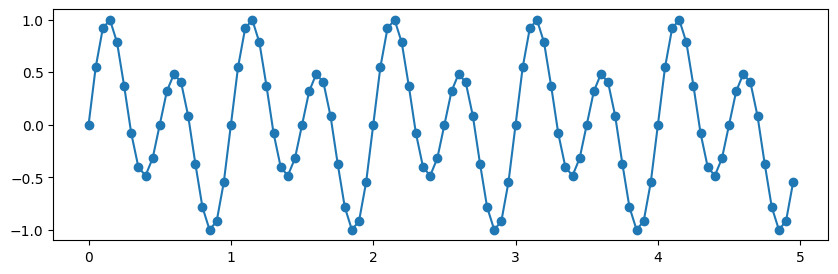

In [ ]:
plt.figure(figsize=(10,3))
plt.plot(t[0:100], raw_seq[0:100],'-o')
plt.show()

Definimos la funcion `split_sequence` que toma como entrada la serie temporal y la cantidad de puntos que vamos a mirar para predecir el siguiente, llamada `look_back`. A partir de estos dos valores genera un dataset moviendo esta ventana de tamaño `look_back` a lo largo de la serie temporal.

In [ ]:
def split_sequence(sequence, look_back):
    X, y = list(), list()
    # Recorremos la serie correspondiente al train y armamos el dataset
    for i in range(look_back, len(sequence)):
        X.append(sequence[i-look_back:i])
        y.append(sequence[i])
    X, y = np.array(X), np.array(y)
    return X, y

Definimos una ventana temporal de 5 valores y generamos nuestro dataset a partir de la señal temporal. Notemos que al ser una señal de un único valor (es una señal escalar), entonces la cantidad de features por cada paso temporal `n_features` es igual a 1. (en el caso general, podríamos aplicar la misma mecánica a series multivariadas).

In [ ]:
# choose a number of time steps
look_back = 5

# Cantidad de valores por cada paso temporal
n_features = 1

# split into samples
X, y = split_sequence(raw_seq, look_back)

# Le damos la forma adecuada a los datos para entrar a la red recurrente
# reshape from [samples, timesteps] into [samples, look_back, features]
X = X.reshape((X.shape[0], X.shape[1], n_features))

print(X.shape)
print(y.shape)

(795, 5, 1)
(795,)


Por último separamos la señal en train y test:

In [ ]:
# Proporcion entre train y test
proporcion = 0.75

# Indice de separacion entre train y test
indice_test = int(proporcion * X.shape[0])

X_train = X[:indice_test]
y_train = y[:indice_test]
X_test = X[indice_test:]
y_test = y[indice_test:]

### 1.2) Entrenando el modelo

Para definir una red recurrente vamos a construir un modelo secuencial igual que lo hicimos en los Notebooks 4 y 5. Con la diferencia que esta vez debemos agregar a nuestro modelo una capa `SimpleRNN` o `LSTM`, dependiendo el tipo de red recurrente que querramos.

Luego de la capa recurrente, debemos agregar una capa densa, la cual leerá el último estado del **hidden space**. En este caso, al tener un problema de regresión en el cual la salida del modelo debe ser un único valor numérico, vamos a utilizar como capa de salida una única unidad con activación lineal.

Si quieren leer con mas detalle sobre Redes Recurrente y LSTMs, les recomiendo [este artículo](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) sobre el tema.

In [ ]:
# Definimos el modelo Secuencial
model = Sequential()

# Agregamos la capa Recurrente (Puede ser LSTM o RNN)
model.add(SimpleRNN(10, activation='tanh', input_shape=(look_back, n_features)))
# model.add(LSTM(20, activation='tanh', input_shape=(look_back, n_features)))

# Agregamos la capa de salida (lee el hidden Space de la recurrente)
model.add(Dense(1,activation='linear'))

# Compilamos el modelo
model.compile(optimizer='adam', loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Ya podemos entrenar nuestro modelo:

In [ ]:
history = model.fit(X_train, y_train, epochs=200, verbose=0,validation_data=(X_test, y_test))

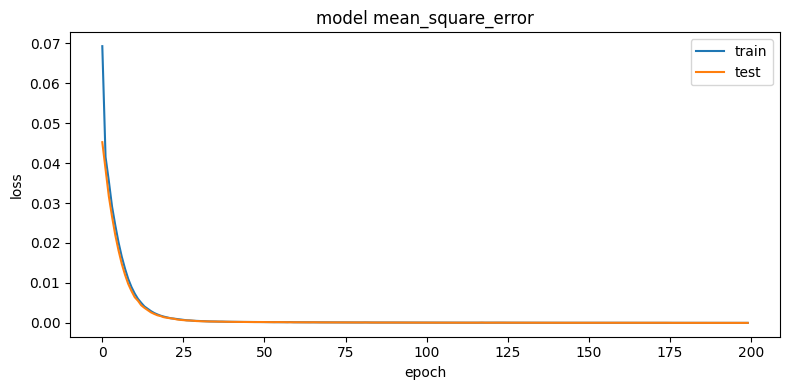

In [ ]:
# plotting the metrics
fig = plt.figure(figsize = (8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean_square_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
# plt.ylim(0.00,0.04)
plt.tight_layout()

### 1.3) Evaluando el resultado

Podemos mirar el error para algún valor particular del test set, pero esto no es muy informativo.

In [ ]:
# Podemos inspeccionar para algun valor particular del test set
numero = 4
x_input = X_test[numero]
x_input = x_input.reshape((1, look_back, n_features))
yhat = model.predict(x_input, verbose=0)
print('Prediccion:', yhat[0][0])
print('Real:',y_test[numero])

Prediccion: 0.37134045
Real: 0.36884988549197395


Para evaluar mejor el modelo, podemos ver que sucede cuando intento predecir multiples pasos en el tiempo. Para realizar esto, debemos predecir el siguiente paso y luego usar ese mismo paso como entrada de la proxima predicción y así sucesivamente.

Con este fin vamos a definirnos la función `prediccion_pasos_adelante` cuya función es, a partir de una instancia dada, evolucionar el modelo N pasos hacia adelante.

In [ ]:
from keras.layers import LSTM, SimpleRNN, Dense

def prediccion_pasos_adelante(model,vec_actual,pasos_adelante):

    # Preparamos una lista vacia que vamos a ir llenando con los valores predichos
    lista_valores = []
    # Recorremos n pasos hacia adelante
    for i in range(pasos_adelante):

        # Predecimos el paso siguiente
        # Check the type of the first layer to determine the expected input shape
        if isinstance(model.layers[0], (LSTM, SimpleRNN)):
            # Recurrent model expects input shape (samples, timesteps, features)
            # Ensure vec_actual has an extra dimension for features if it's missing
            if len(vec_actual.shape) == 2: # Already (timesteps, features)
                 input_vec = vec_actual.reshape((1, vec_actual.shape[0], vec_actual.shape[1]))
            else: # Assume it's (timesteps,) and add feature dimension
                input_vec = vec_actual.reshape((1, vec_actual.shape[0], 1))

        elif isinstance(model.layers[0], Dense):
            # Dense model expects input shape (samples, features)
            # Flatten the timesteps and features into a single feature dimension if necessary
            if len(vec_actual.shape) == 2: # (timesteps, features) -> (features,) then reshape to (1, features)
                 input_vec = vec_actual.flatten().reshape(1, -1)
            else: # (timesteps,) -> (features,) then reshape to (1, features)
                input_vec = vec_actual.reshape(1, vec_actual.shape[0])
        else:
            raise TypeError("Unsupported layer type in the first layer of the model")

        nuevo_valor = model.predict(input_vec, verbose=0)

        # Lo agregamos a la lista
        lista_valores.append(nuevo_valor[0][0])

        # Actualizmaos el vector actual con este paso
        vec_actual = np.roll(vec_actual, -1)
        vec_actual[-1] = nuevo_valor[0][0]

    lista_valores = np.asarray(lista_valores)

    return lista_valores

Calculemos con nuestro modelo entrenado una predicción de 100 pasos adelante y comparemosla con la señal real.

In [ ]:
# Cantidad de pasos que queremos predecir hacia adelante
pasos_adelante = 100
indice_inicial = 0

# Tomamos un valor inicial del test set
vec_actual = X_test[indice_inicial]

# Calculamos la prediccion del modelo
predicciones_adelante = prediccion_pasos_adelante(model,vec_actual,pasos_adelante)

# Tomamos los valores esperados
valores_reales = y_test[indice_inicial:indice_inicial+pasos_adelante]

# Calculamos el error
diferencia = np.abs(predicciones_adelante-valores_reales)

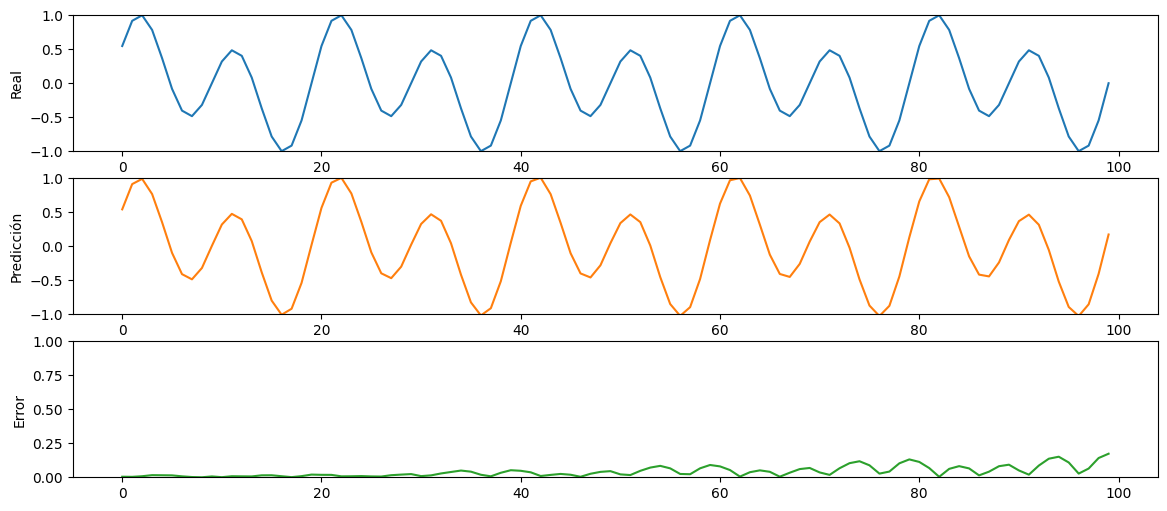

In [ ]:
fig = plt.figure(figsize = (14,6))
plt.subplot(3,1,1)
plt.plot(valores_reales)
plt.ylabel('Real')
plt.ylim(-1,1)
plt.subplot(3,1,2)
plt.plot(predicciones_adelante,c='C1')
plt.ylabel('Predicción')
plt.ylim(-1,1)
plt.subplot(3,1,3)
plt.plot(diferencia,c='C2')
plt.ylabel('Error')
plt.ylim(0,1)
plt.show()

**Reflexionar:** ¿Les parece buena la predicción que está logrando el modelo de la señal? ¿Cómo la evaluarían de una manera mas sistemática?

## 2) Comparación con una Red Densa Clásica

En el notebook de la clase 4 usamos una red densa de regresión para predecir el siguiente valor en una serie temporal proviniente de un atractor de Rossler. Vamos a volver a realizar el mismo procedimiento, pero esta vez vamos a comparar el resultado de la predicción de esta red densa con una predicción hecha mediante una Red Recurrente.

### 2.1) Generacion del Dataset
Vamos a generar la serie temporal caótica de la misma forma que en la Practica 5.

In [ ]:
def ecuaciones(x,y,z, a=0.1, b=0.1, c=14):
    '''
    Recibe:
       x, y: Variables del sistema
       param: Lista con los parámetros del sistema
    Devuelve:
       x_dot, y_dot: valor de las derivadas para cada variable
    '''
    x_dot = 1*(-y - z)
    y_dot = 1*(x + a*y)
    z_dot = 1*(b + z*(x - c))

    return x_dot, y_dot, z_dot


def integrar_ecuaciones(total_time,dt,X0):

    '''
    Recibe:
       total_time: Tiempo total del integración
       dt: Paso temporal (h del método)
       X0: Lista con [x0,y0] valores iniciales de la integración
       params: Lista con los parámetros del sistema
    Devuelve:
       x_s, y_s: Vectores con las soluciones para ambas variables
       num_steps: Numero de pasos de integracion
    '''

    num_steps = int(np.divide(total_time,dt))

    # Empty vectors
    xs = np.empty(num_steps)
    ys = np.empty(num_steps)
    zs = np.empty(num_steps)

    # Set initial values
    xs[0], ys[0], zs[0] = X0

    # Empty vectors
    x_dot = np.empty(num_steps)
    y_dot = np.empty(num_steps)
    z_dot = np.empty(num_steps)

    # Set initial derivatives values
    x_dot[0], y_dot[0], z_dot[0] = ecuaciones(xs[0], ys[0], zs[0])

    # Integramos con método de Euler
    for i in range(num_steps-1):
        x_dot[i], y_dot[i], z_dot[i] = ecuaciones(xs[i], ys[i], zs[i])
        xs[i + 1] = xs[i] + (x_dot[i] * dt)
        ys[i + 1] = ys[i] + (y_dot[i] * dt)
        zs[i + 1] = zs[i] + (z_dot[i] * dt)

    return xs, ys, zs, num_steps

In [ ]:
# Simulamos los datos
total_time = 5000
dt = 0.005
X0 = (10, 10, 0)

xs, ys, zs, num_steps = integrar_ecuaciones(total_time,dt,X0)

Normalizamos y subsampleamos la a serie temporal.

In [ ]:
# Proporcion entre train y test
proporcion = 0.75

# Indice de separacion entre train y test
indice_test = int(proporcion * num_steps)

# Subsampleo temporal de la señal
subsampleo = 100

# Maximo de la señal para normalizar
maximo = np.max(np.abs(xs))

# Separamos la serie en 2 partes, una para el train set y otra para el test set.
training_set_scaled = np.divide(xs[:indice_test:subsampleo],maximo)
test_set_scaled = np.divide(xs[indice_test::subsampleo],maximo)

Ahora, armaremos el dataset a utilizar a partir de esta serie temporal. Entrenaremos la red de manera de que la entrada sean N pasos consecutivos de la serie y su objetivo sea predecir el siguiente paso.

La cantidad de pasos para atras que verá la red esta determinada por la variable `look_back`.

In [ ]:
# Definimos los pasos a mirar hacia atrás
look_back = 30

# Con la serie correspondiente al train armamos el dataset
X_train, Y_train = split_sequence(training_set_scaled, look_back)

# Con la serie correspondiente al test armamos el dataset
X_test, Y_test = split_sequence(test_set_scaled, look_back)

Noten las dimensiones de las matrices obtenidas.

In [ ]:
# print the final input shape ready for training
print("Train matrix shape", X_train.shape)
print("Train y shape", Y_train.shape)

print("Test matrix shape", X_test.shape)
print("Test y shape", Y_test.shape)

Train matrix shape (7470, 30)
Train y shape (7470,)
Test matrix shape (2470, 30)
Test y shape (2470,)


### 2.2) Entrenando la red densa

Vamos a definir una red neuronal densa para un problema de regresión de la misma forma que lo hicimos en el Notebook 5.

In [ ]:
# building a linear stack of layers with the sequential model
model_dense = Sequential()
model_dense.add(Dense(8, activation='relu', input_shape=(look_back,)))
# model_dense.add(Dropout(0.2))

model_dense.add(Dense(8, activation='relu'))
# model_dense.add(Dropout(0.2))

model_dense.add(Dense(4, activation='relu'))
# model_dense.add(Dropout(0.2))

model_dense.add(Dense(1, activation='linear'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# compiling the sequential model
model_dense.compile(loss='mse', metrics=['mean_absolute_error'], optimizer='adam')

Veamos cual es la cantidad de parámetros totales que posée este modelo, ya que si queremos compararlo con la red recurrente, lo mas justo sería comparar modelos de un tamaño similar.

In [ ]:
model_dense.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 8)              │           248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 361 (1.41 KB)

 Trainable params: 361 (1.41 KB)

 Non-trainable params: 0 (0.00 B)

Ya podemos entrenar nuestrad red regresora.

In [ ]:
# training the model and saving metrics in history
history_dense = model_dense.fit(X_train, Y_train,
          batch_size=32, epochs=50,
          verbose=2,
          validation_data=(X_test, Y_test))

Epoch 1/50
234/234 - 2s - 10ms/step - loss: 0.1020 - mean_absolute_error: 0.2359 - val_loss: 0.0120 - val_mean_absolute_error: 0.0857
Epoch 2/50
234/234 - 1s - 3ms/step - loss: 0.0111 - mean_absolute_error: 0.0810 - val_loss: 0.0079 - val_mean_absolute_error: 0.0682
Epoch 3/50
234/234 - 1s - 3ms/step - loss: 0.0070 - mean_absolute_error: 0.0613 - val_loss: 0.0053 - val_mean_absolute_error: 0.0528
Epoch 4/50
234/234 - 1s - 3ms/step - loss: 0.0044 - mean_absolute_error: 0.0474 - val_loss: 0.0038 - val_mean_absolute_error: 0.0435
Epoch 5/50
234/234 - 1s - 5ms/step - loss: 0.0032 - mean_absolute_error: 0.0391 - val_loss: 0.0029 - val_mean_absolute_error: 0.0362
Epoch 6/50
234/234 - 1s - 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0345 - val_loss: 0.0025 - val_mean_absolute_error: 0.0324
Epoch 7/50
234/234 - 1s - 5ms/step - loss: 0.0023 - mean_absolute_error: 0.0313 - val_loss: 0.0023 - val_mean_absolute_error: 0.0325
Epoch 8/50
234/234 - 1s - 4ms/step - loss: 0.0021 - mean_absolute_er

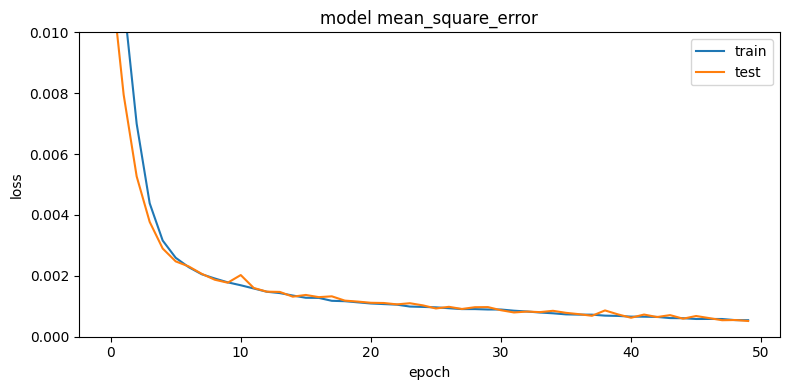

In [ ]:
# plotting the metrics
fig = plt.figure(figsize = (8,4))
plt.plot(history_dense.history['loss'])
plt.plot(history_dense.history['val_loss'])
plt.title('model mean_square_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0,0.01)
plt.tight_layout()

### 2.2) Entrenando la Red Recurrente

Entrenar la red recurrente será muy similar, pero debemos recordar acomodar el shape de los datos de la siguiente forma:

In [ ]:
X_train_recurrente = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test_recurrente = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

print("Train matrix shape", X_train_recurrente.shape)
print("Test matrix shape", X_test_recurrente.shape)

Train matrix shape (7470, 30, 1)
Test matrix shape (2470, 30, 1)


Ahora si, definamos nuestra red recurrente con una unica capa LSTM y una capa densa de salida.

In [ ]:
# Definimos el modelo
model_recurrente = Sequential()

# Capa Recurrente (Puede ser LSTM o RNN)
model_recurrente.add(LSTM(8, activation='tanh', input_shape=(look_back, n_features),unroll=True))

# Como capa de salida (lee el hidden Space de la recurrente)
model_recurrente.add(Dense(1,activation='linear'))

# compiling the sequential model
model_recurrente.compile(loss='mse', metrics=['mean_absolute_error'], optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Noten que la cantidad de parámetros es un poco menor pero del mismo orden que la red densa.

In [ ]:
model_recurrente.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 8)              │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 329 (1.29 KB)

 Trainable params: 329 (1.29 KB)

 Non-trainable params: 0 (0.00 B)

Ahora si, entrenemos la red.

In [ ]:
# training the model and saving metrics in history
history_recurrente = model_recurrente.fit(X_train_recurrente, Y_train,
          batch_size=32, epochs=50,
          verbose=2,
          validation_data=(X_test_recurrente, Y_test))

Epoch 1/50
234/234 - 9s - 39ms/step - loss: 0.1892 - mean_absolute_error: 0.3654 - val_loss: 0.0236 - val_mean_absolute_error: 0.1325
Epoch 2/50
234/234 - 5s - 19ms/step - loss: 0.0067 - mean_absolute_error: 0.0560 - val_loss: 0.0048 - val_mean_absolute_error: 0.0481
Epoch 3/50
234/234 - 2s - 9ms/step - loss: 0.0046 - mean_absolute_error: 0.0459 - val_loss: 0.0042 - val_mean_absolute_error: 0.0451
Epoch 4/50
234/234 - 2s - 8ms/step - loss: 0.0043 - mean_absolute_error: 0.0448 - val_loss: 0.0039 - val_mean_absolute_error: 0.0418
Epoch 5/50
234/234 - 3s - 11ms/step - loss: 0.0041 - mean_absolute_error: 0.0434 - val_loss: 0.0039 - val_mean_absolute_error: 0.0418
Epoch 6/50
234/234 - 2s - 11ms/step - loss: 0.0039 - mean_absolute_error: 0.0419 - val_loss: 0.0035 - val_mean_absolute_error: 0.0383
Epoch 7/50
234/234 - 3s - 13ms/step - loss: 0.0037 - mean_absolute_error: 0.0402 - val_loss: 0.0034 - val_mean_absolute_error: 0.0370
Epoch 8/50
234/234 - 2s - 10ms/step - loss: 0.0035 - mean_absolu

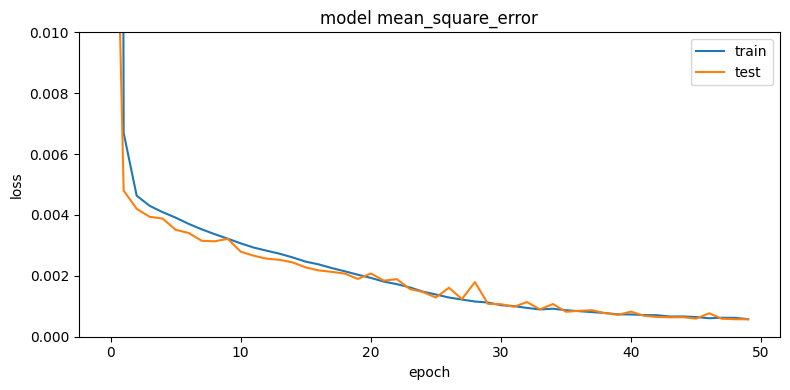

In [ ]:
# plotting the metrics
fig = plt.figure(figsize = (8,4))
plt.plot(history_recurrente.history['loss'])
plt.plot(history_recurrente.history['val_loss'])
plt.title('model mean_square_error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.ylim(0,0.01)
plt.tight_layout()

### 2.3) Analizamos los resultados

Vamos a utilizar ambos modelos para realizar predicciones de multiples pasos en el futuro y comparar los errores obtenidos por cada uno.


In [ ]:
pasos_adelante = 100
inicio = 0

# Tomamos los valores esperados
valores_reales = Y_test[inicio:inicio+pasos_adelante]

# Tomamos el primer vector del X_test
principio = X_test[inicio]
# Reshape for the dense model - Removed explicit reshape here
predicciones_adelante_dense = prediccion_pasos_adelante(model_dense,principio,pasos_adelante)
diferencia_dense = np.abs(predicciones_adelante_dense-valores_reales)

# Tomamos el primer vector del X_test
principio_recurrente = X_test_recurrente[inicio]
predicciones_adelante_recurrente = prediccion_pasos_adelante(model_recurrente,principio_recurrente,pasos_adelante)
diferencia_recurrente = np.abs(predicciones_adelante_recurrente-valores_reales)

Geafiquemos el error de cada predicción en función del tiempo y comparemos.

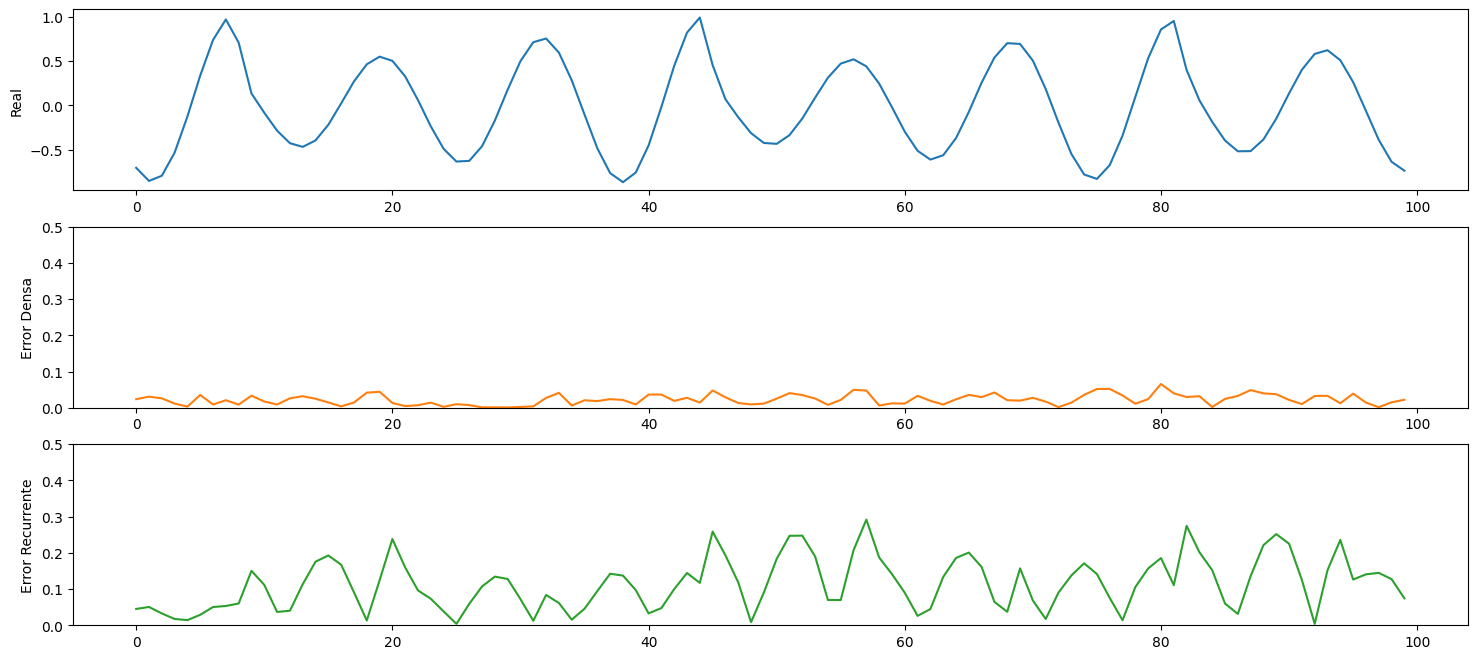

In [ ]:
fig = plt.figure(figsize = (18,8))
plt.subplot(3,1,1)
plt.plot(valores_reales)
plt.ylabel('Real')
plt.subplot(3,1,2)
plt.plot(diferencia_dense,c='C1')
plt.ylabel('Error Densa')
plt.ylim(0,0.5)
plt.subplot(3,1,3)
plt.plot(diferencia_recurrente,c='C2')
plt.ylabel('Error Recurrente')
plt.ylim(0,0.5)
plt.show()

**Ejercicios:**

*   Si cambia la posición inicial (cambiando la variable `inicio`) verá que cambian los errores de predicción de los modelos. Compute el promedio de los errores para varios inicios diferentes en ambos modelos y compare esas curvas promediadas.

*   ¿Les parece esta una manera adecuada de visualizar los errores? Diseñe una estrategia para cuantificar mejor el error de cada red en función del numero de pasos adelante.

*   Pruebe modificar la arquitectura de ambas redes, tanto la densa como la recurrente, y vuelva a comparar los errores cometidos. Pruebe con redes de un menor número de parámetros (siempre intentando mantener los valores parejos entre ambas).

*   ¿Les parece que este es un sistema facil para hacer predicciones?


**Observación Importante:** La comparación realizada en esta sección es de caracter demostrativo. Para realizar una comparación rigurosa, uno debería optimizar los hiperparámetros para cada uno de los modelos utilizando cross-validation y generar varias relizaciones del proceso.

In [ ]:
pasos_adelante = 50
iteraciones = 100
errores_dense = np.zeros((iteraciones,pasos_adelante))
errores_recurrente = np.zeros((iteraciones,pasos_adelante))
vec_inicio = np.arange(0,iteraciones)

for i in range(len(vec_inicio)):

    print('Paso ',i,'de ',iteraciones)
    inicio = vec_inicio[i]

    # Tomamos los valores esperados
    valores_reales = Y_test[inicio:inicio+pasos_adelante]

    # Tomamos el primer vector del X_test
    principio = X_test[inicio]
    predicciones_adelante_dense = prediccion_pasos_adelante(model_dense,principio,pasos_adelante)
    diferencia_dense = np.abs(predicciones_adelante_dense-valores_reales)

    # Tomamos el primer vector del X_test
    principio_recurrente = X_test_recurrente[inicio]
    predicciones_adelante_recurrente = prediccion_pasos_adelante(model_recurrente,principio_recurrente,pasos_adelante)
    diferencia_recurrente = np.abs(predicciones_adelante_recurrente-valores_reales)

    errores_dense[i,:] = diferencia_dense
    errores_recurrente[i,:] = diferencia_recurrente

Paso  0 de  100
Paso  1 de  100
Paso  2 de  100
Paso  3 de  100
Paso  4 de  100
Paso  5 de  100
Paso  6 de  100
Paso  7 de  100
Paso  8 de  100
Paso  9 de  100
Paso  10 de  100
Paso  11 de  100
Paso  12 de  100
Paso  13 de  100
Paso  14 de  100
Paso  15 de  100
Paso  16 de  100
Paso  17 de  100
Paso  18 de  100
Paso  19 de  100
Paso  20 de  100
Paso  21 de  100
Paso  22 de  100
Paso  23 de  100
Paso  24 de  100
Paso  25 de  100
Paso  26 de  100
Paso  27 de  100
Paso  28 de  100
Paso  29 de  100
Paso  30 de  100
Paso  31 de  100
Paso  32 de  100
Paso  33 de  100
Paso  34 de  100
Paso  35 de  100
Paso  36 de  100
Paso  37 de  100
Paso  38 de  100
Paso  39 de  100
Paso  40 de  100
Paso  41 de  100
Paso  42 de  100
Paso  43 de  100
Paso  44 de  100
Paso  45 de  100
Paso  46 de  100
Paso  47 de  100
Paso  48 de  100
Paso  49 de  100
Paso  50 de  100
Paso  51 de  100
Paso  52 de  100
Paso  53 de  100
Paso  54 de  100
Paso  55 de  100
Paso  56 de  100
Paso  57 de  100
Paso  58 de  100
Paso  5

In [ ]:
promedio_dense = np.mean(errores_dense, axis = 0)
std_dense = np.std(errores_dense, axis = 0)

promedio_recurrente = np.mean(errores_recurrente, axis = 0)
std_recurrente = np.std(errores_recurrente, axis = 0)

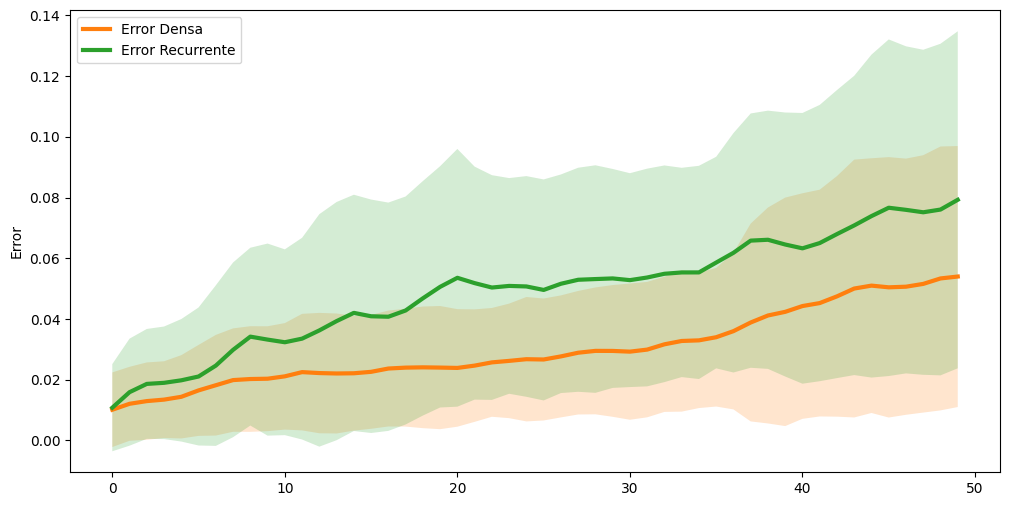

In [ ]:
fig = plt.figure(figsize = (12,6))
t = np.arange(pasos_adelante)
plt.fill_between(t, promedio_dense+std_dense, promedio_dense-std_dense, facecolor='C1', alpha=0.2)
plt.fill_between(t, promedio_recurrente+std_recurrente, promedio_recurrente-std_recurrente, facecolor='C2', alpha=0.2)
plt.plot(t, promedio_dense,c='C1',label='Error Densa',linewidth=3)
plt.plot(t, promedio_recurrente,c='C2',label='Error Recurrente',linewidth=3)

plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
len(predicciones_adelante_dense)

50